## Analysis Summary 
Task: Analyze sales over 2 days from 2 different stores

Assumptions: 
* The distribution of sales and items are similar throughout the week. (The weekend might sell more items but # upcs sold is about the same)

### High Level Findings
#### Store #2222 is definately a Super Walmart
* Store #2222 sold 46,086 unique upc items.
* Store #3333 sold 5,752 unique upc items.

#### Store #3333 seems to be a more effecient store (Sam's Club? Who buys $22 of Twizzlers?)
* It holds less unique items but proportionally sells more. Store #2222 moved 4.8x inventory but only 2.3x more gross sales. 
* Open less hours than store #2222
* Store #2222 supports 8x more unique upc items
* Store #3333 sells less items for more money across less hours. It has reduced overhead due to supporting a less diverse inventory.

### Data Findings
#### Comparison using Department numbers is difficult
* Department numbers are not standardized. 
* Example twizzlers is sold in multiple departments in #2222 but only 1 in #3333
* It is unknown how departments are organized either by category or location.

#### Comparison using UPC numbers is difficult
* 4 UPC numbers matched across stores
* 415 items matched using name

### Further Work
* Implement product categorization
Current limitations: Need truth labels
Example approach:
https://techblog.commercetools.com/boosting-product-categorization-with-machine-learning-ad4dbd30b0e8
* Compare department locations across stores (back of store A vs back of store B)
* Compare product categories across stores (determine difference in electronic sales etc)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read data
sales_data = pd.read_csv('4729-2038.tsv', sep='\t')
sales_data.head()

,id,order_id,order_time,store_number,department,register,amount,upc,name,description
0,44098873602538434607-0000000000715756200020-1,44098873602538434607,1500720834000,2222,94,43,1.98,0000000000715756200020,STRAWBERRIES,STRAWBERRY 1
1,44098873602538434607-0000000000074641006050-2,44098873602538434607,1500720834000,2222,94,43,2.48,0000000000074641006050,RED GRAPES,RED GRAPES 10Z CF
2,44098873602538434607-0000000000078742147150-3,44098873602538434607,1500720834000,2222,92,43,3.92,0000000000078742147150,GV OR PB CRN,GV ORG PB CRUNCHY
3,44098873602538434607-0000000000078742116760-4,44098873602538434607,1500720834000,2222,4,43,2.48,0000000000078742116760,ASST CUTLERY,GV PRM FS ASST 48CT
4,44098873602538434607-0000000000016000432680-5,44098873602538434607,1500720834000,2222,92,43,3.77,0000000000016000432680,GRANOLA,NV OAT N HNY GRAN


In [3]:
# stores
sales_data['store_number'].unique()

array([2222, 3333])

In [4]:
# no of unique items sold per store
sales_data.groupby('store_number')['upc'].nunique()

store_number
2222    46086
3333     5752
Name: upc, dtype: int64

In [5]:
# no of departments per store
sales_data.groupby(['store_number'])['department'].nunique()

store_number
2222    67
3333    84
Name: department, dtype: int64

In [6]:
# no of inventory sold per store
sales_data.groupby('store_number')['id'].count()

store_number
2222    176773
3333     36722
Name: id, dtype: int64

In [7]:
sales_data.groupby('store_number')['amount'].sum()

store_number
2222    838234.189999
3333    358681.460000
Name: amount, dtype: float64

In [8]:
sales_data['order_time'].head() # looks like epoch time with miliseconds

0    1500720834000
1    1500720834000
2    1500720834000
3    1500720834000
4    1500720834000
Name: order_time, dtype: int64

In [9]:
# check how many rows end with 000
sales_data['order_time'][~sales_data['order_time'].astype(str).str.endswith("000")]

Series([], Name: order_time, dtype: int64)

In [10]:
# convert order_time column to datetime object
sales_data['order_time'] = pd.to_datetime(sales_data['order_time'],unit='ms')
sales_data['order_time'].head()

0   2017-07-22 10:53:54
1   2017-07-22 10:53:54
2   2017-07-22 10:53:54
3   2017-07-22 10:53:54
4   2017-07-22 10:53:54
Name: order_time, dtype: datetime64[ns]

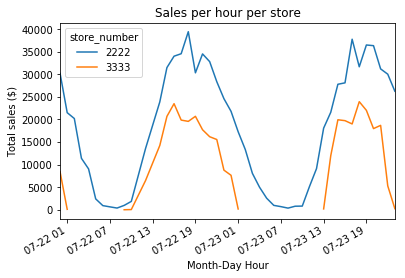

In [11]:
# plot amount of money made total per hour for each store
sales_data.groupby([pd.TimeGrouper(key='order_time', freq='H'), 'store_number'])['amount'].sum().unstack().plot()
plt.xlabel("Month-Day Hour")
plt.ylabel("Total sales ($)")
plt.title("Sales per hour per store")
plt.show()

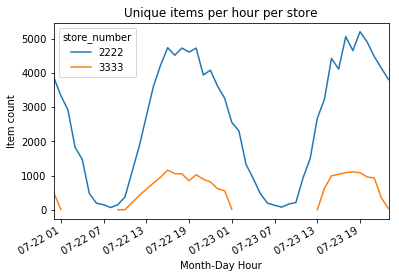

In [12]:
sales_data.groupby([pd.TimeGrouper(key='order_time', freq='H'), 'store_number'])['upc'].nunique().unstack().plot()
plt.xlabel("Month-Day Hour")
plt.ylabel("Item count")
plt.title("Unique items per hour per store")
plt.show()

In [13]:
# create order statistics
date = sales_data['order_time']
total_order_price = pd.DataFrame(sales_data.groupby(['store_number', 'order_id'])['amount'].sum())
total_order_price.columns = ['order_amount']
total_order_price.reset_index(inplace=True)

count_order_items = pd.DataFrame(sales_data.groupby(['store_number', 'order_id'])['upc'].count())
count_order_items.columns = ['item_count']
count_order_items.reset_index(inplace=True)


average_amount_items = pd.DataFrame(sales_data.groupby(['store_number', 'order_id'])['amount'].mean())
average_amount_items.columns = ['item_amount_average']
average_amount_items.reset_index(inplace=True)

order_data = total_order_price.merge(sales_data).merge(count_order_items).merge(average_amount_items)
order_data = order_data[['order_time','order_id', 'store_number', 'order_amount', 'item_count', 'item_amount_average']].drop_duplicates()
order_data.head()

,order_time,order_id,store_number,order_amount,item_count,item_amount_average
0,2017-07-23 21:28:52,00006280410953249418,2222,47.22,8,5.902500
8,2017-07-23 17:17:20,00006280468956221468,2222,38.97,1,38.970000
9,2017-07-23 22:04:57,00006382436950267448,2222,40.42,15,2.694667
24,2017-07-23 14:07:37,00006586436954237438,2222,43.98,5,8.796000
29,2017-07-23 18:46:19,00006681446956273468,2222,39.54,7,5.648571


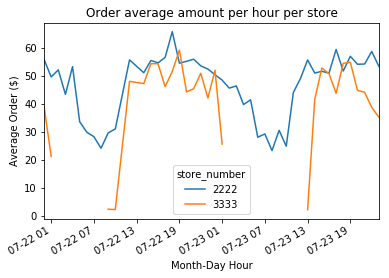

In [14]:
# plot average transaction amount per hour for each store across both days
order_data.groupby([pd.TimeGrouper(key='order_time', freq='H'), 'store_number'])['order_amount'].mean().unstack().plot()
plt.xlabel("Month-Day Hour")
plt.ylabel("Average Order ($)")
plt.title("Order average amount per hour per store")
plt.show()

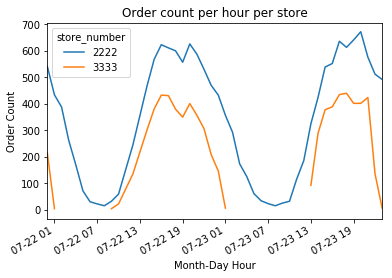

In [15]:
order_data.groupby([pd.TimeGrouper(key='order_time', freq='H'), 'store_number'])['order_id'].count().unstack().plot()
plt.xlabel("Month-Day Hour")
plt.ylabel("Order Count")
plt.title("Order count per hour per store")
plt.show()

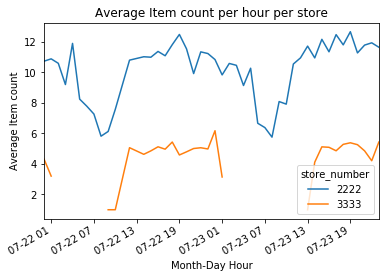

In [16]:
order_data.groupby([pd.TimeGrouper(key='order_time', freq='H'), 'store_number'])['item_count'].mean().unstack().plot()
plt.xlabel("Month-Day Hour")
plt.ylabel("Average Item count")
plt.title("Average Item count per hour per store")
plt.show()

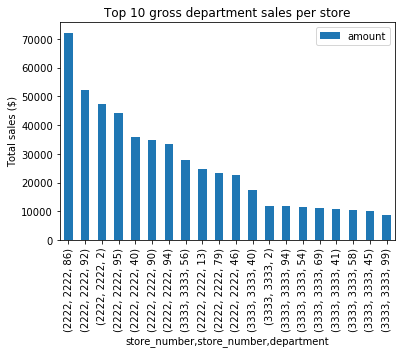

In [17]:
dept_sales = sales_data.groupby(['store_number', 'department'])['amount'].sum().groupby(level=0).nlargest(10)
pd.DataFrame(dept_sales).sort_values('amount', ascending=False).plot.bar()
plt.ylabel("Total sales ($)")
plt.title("Top 10 gross department sales per store")
plt.show()

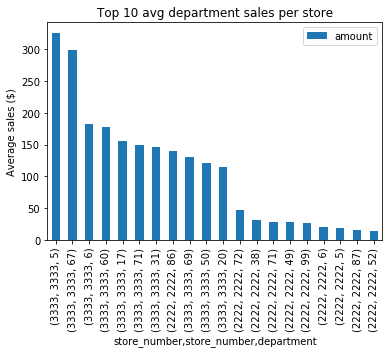

In [18]:
dept_sales = sales_data.groupby(['store_number', 'department'])['amount'].mean().groupby(level=0).nlargest(10)
pd.DataFrame(dept_sales).sort_values('amount', ascending=False).plot.bar()
plt.ylabel("Average sales ($)")
plt.title("Top 10 avg department sales per store")
plt.show()

In [19]:
## Top 3 department 3333
# TV electronic
# sales_data[(sales_data['store_number'] == 3333)
#           & (sales_data['department'] == 5)]['description'].head()

# jewelry
# sales_data[(sales_data['store_number'] == 3333)
#           & (sales_data['department'] == 67)]['description'].head()

# camera electronic
# sales_data[(sales_data['store_number'] == 3333)
#           & (sales_data['department'] == 6)]['description'].head()


## Top 4 department 222
# bill pay check cash
# sales_data[(sales_data['store_number'] == 2222)
#           & (sales_data['department'] == 86)]['description'].head()

# electronic
# sales_data[(sales_data['store_number'] == 2222)
#           & (sales_data['department'] == 72)]['description'].head()

# pharmacy
# sales_data[(sales_data['store_number'] == 2222)
#           & (sales_data['department'] == 38)]['description'].head()

# furniture
# sales_data[(sales_data['store_number'] == 2222)
#           & (sales_data['department'] == 71)]['description'].head()

In [20]:
# only 4 common upc numbers

# products that sell at both stores
s1 = sales_data[sales_data['store_number'] == 2222]['name']
s2 = sales_data[sales_data['store_number'] == 3333]['name']
common_name = pd.Series(list(set(s1).intersection(set(s2))))
common_name = pd.DataFrame(common_name)
common_name.columns = ['common_name']
print(common_name.shape)
common_name.head()

(415, 1)


,common_name
0,SALSA
1,SKIM MILK
2,SWIFFER
3,LENS WIPES
4,NECTARINES


In [42]:
sales_data[(sales_data['name'] == 'TWIZZLERS')][['store_number', 'department', 'amount', 'name', 'description']].drop_duplicates()

,store_number,department,amount,name,description
8377,2222,82,1.34,TWIZZLERS,TWIZZLER KING 5OZ
8378,2222,82,-1.34,TWIZZLERS,TWIZZLER KING 5OZ
23803,2222,1,5.98,TWIZZLERS,TWIZ ASST RAINBOW
36345,2222,1,3.74,TWIZZLERS,TWIZLR TWST STRW FAM
41121,2222,1,3.74,TWIZZLERS,TWIZLR PNP CHRY FAM
174504,3333,1,21.98,TWIZZLERS,TWIZZLERS STRAWBERRY
191555,2222,1,1.84,TWIZZLERS,TWIZZLER RAINBOW MED


In [22]:
# Find products that sell in both store
store_a = sales_data[sales_data['store_number'] == 2222]
store_b = sales_data[sales_data['store_number'] == 3333]

In [23]:
common_a = store_a.merge(common_name, left_on="name", right_on="common_name")
print("From common item sales:")
print("Average item price sold:", common_a['amount'].mean())
print("Number of inventory sold:", common_a['id'].count())
print("Average transaction amount:", common_a.groupby('order_id')['amount'].sum().mean())
print("Total sales:", common_a['amount'].sum())

From common item sales:
Average item price sold: 3.5268357753359183
Number of inventory sold: 16380
Average transaction amount: 8.641670905011276
Total sales: 57769.57000000234


In [24]:
common_b = store_b.merge(common_name, left_on="name", right_on="common_name")
print("From common item sales:")
print("Average item price sold:", common_b['amount'].mean())
print("Number of inventory sold:", common_b['id'].count())
print("Average transaction amount:", common_b.groupby('order_id')['amount'].sum().mean())
print("Total sales:", common_b['amount'].sum())

From common item sales:
Average item price sold: 7.744085163824442
Number of inventory sold: 8149
Average transaction amount: 23.372796296296382
Total sales: 63106.55000000538


In [25]:
store_a.count()

id              176773
order_id        176773
order_time      176773
store_number    176773
department      176773
register        176773
amount          176773
upc             176773
name            176773
description     176707
dtype: int64

In [26]:
# multiply arrays of num sold per hour and determine if something comes back
# indicator arrays of when products we sold
# use XOR to find where selling in one but not other

In [27]:
# normalize departments (1 walart has gasoline the other does not)
# department mapping

In [28]:
# product categorization

In [29]:
sales_data[(sales_data['store_number'] == 2222) & 
           (sales_data['department'] == 40) &
          (sales_data['upc'] == "0000000000312547171570")
          ].head()

,id,order_id,order_time,store_number,department,register,amount,upc,name,description
69,15841703399468542370-0000000000312547171570-16,15841703399468542370,2017-07-22 10:38:49,2222,40,49,5.32,0000000000312547171570,BENADRYL GEL,BENADRYL ES ITCH GEL
28155,48079658729102811775-0000000000312547171570-7,48079658729102811775,2017-07-22 10:43:01,2222,40,18,5.32,0000000000312547171570,BENADRYL GEL,BENADRYL ES ITCH GEL


In [30]:
sales_data[(sales_data['store_number'] == 3333) & 
#            (sales_data['department'] == 40) &
          (sales_data['name'].str.contains("BENADRYL"))
          ].head()

,id,order_id,order_time,store_number,department,register,amount,upc,name,description
56682,6678292849514811441-0000000000030045055725-2,6678292849514811441,2017-07-22 21:43:58,3333,54,7,13.68,0000000000030045055725,BENADRYL,BENADRYL ULTRA TABS
179618,99241004390265306946-0000000000030045055725-4,99241004390265306946,2017-07-23 20:24:02,3333,54,7,13.68,0000000000030045055725,BENADRYL,BENADRYL ULTRA TABS


In [31]:
sales_data[(sales_data['store_number'] == 2222) & 
#            (sales_data['department'] == 94)
          (sales_data['name'].str.contains("OREO"))
          ]

,id,order_id,order_time,store_number,department,register,amount,upc,name,description
614,16687591824312606839-0000000000884912268390-2,16687591824312606839,2017-07-22 15:24:37,2222,92,43,3.98,0000000000884912268390,OREO O S 19,OREO O S 19OZ
798,37579956759106835705-0000000000044000025410-3,37579956759106835705,2017-07-22 01:44:18,2222,95,10,2.88,0000000000044000025410,OREO,OREO OR PB CR 15.25Z
1457,959655837963027711903-0000000000070221008390-25,959655837963027711903,2017-07-22 00:02:48,2222,82,9,1.34,0000000000070221008390,MILKA OREO K,2.88OZ MILKA OREO KS
1827,04198278687531460697-0000000000044000033230-3,04198278687531460697,2017-07-22 14:21:12,2222,95,5,2.88,0000000000044000033230,OREO,OREO OR MEG ST 13.2Z
2244,492194360236790078266-0000000000044000015920-4,492194360236790078266,2017-07-22 00:40:43,2222,95,9,1.98,0000000000044000015920,OREO,OREO ORG MINI BAG 8Z
2249,492194360236790078266-0000000000044000015920-9,492194360236790078266,2017-07-22 00:40:43,2222,95,9,1.98,0000000000044000015920,OREO,OREO ORG MINI BAG 8Z
2256,492194360236790078266-0000000000044000015920-16,492194360236790078266,2017-07-22 00:40:43,2222,95,9,1.98,0000000000044000015920,OREO,OREO ORG MINI BAG 8Z
2416,56398974678530487677-0000000000044000052480-3,56398974678530487677,2017-07-22 00:26:54,2222,95,10,2.88,0000000000044000052480,10.7Z OREO,OREO JELLY DONUT
2417,56398974678530487677-0000000000044000052480-4,56398974678530487677,2017-07-22 00:26:54,2222,95,10,2.88,0000000000044000052480,10.7Z OREO,OREO JELLY DONUT
2651,92714669242794092286-0000000000044000033270-13,92714669242794092286,2017-07-22 00:35:26,2222,95,22,3.56,0000000000044000033270,OREO,OREO ORG FS 19.1Z


In [32]:
sales_data[(sales_data['store_number'] == 3333) & 
#            (sales_data['department'] == 44)
          (sales_data['name'].str.contains("OREO"))
          ][['store_number', 'department',
       'register', 'amount', 'upc', 'name', 'description']]

,store_number,department,register,amount,upc,name,description
1948,3333,78,5,9.68,0000000000004400004703,OREO 30CT,30CT OREO SINGLES
7017,3333,78,7,9.68,0000000000004400004703,OREO 30CT,30CT OREO SINGLES
7667,3333,78,7,9.68,0000000000004400004703,OREO 30CT,30CT OREO SINGLES
17471,3333,78,13,7.38,0000000000004400007274,OREOS,OREO COOKIES
18160,3333,78,7,7.38,0000000000004400007274,OREOS,OREO COOKIES
18161,3333,78,7,7.38,0000000000004400007274,OREOS,OREO COOKIES
23669,3333,78,5,9.98,0000000000004400001310,MINI OREOS,MINI OREO
30224,3333,78,5,9.68,0000000000004400004703,OREO 30CT,30CT OREO SINGLES
40138,3333,78,4,9.68,0000000000004400004703,OREO 30CT,30CT OREO SINGLES
42773,3333,78,11,9.68,0000000000004400004703,OREO 30CT,30CT OREO SINGLES


In [33]:
sales_data.columns

Index(['id', 'order_id', 'order_time', 'store_number', 'department',
       'register', 'amount', 'upc', 'name', 'description'],
      dtype='object')